#### IDEA

Use the partecipation described here to check the partecipation of the teams in the global market https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2175124/

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from igraph import Graph
import igraph as ig

In [26]:
leagues = pd.read_csv('resources/club_league.csv')
indexed_leagues = leagues.set_index('club_name')
major_leagues = ['1 Bundesliga', 'Ligue 1', 'Serie A', 'Eredivisie','Premier League', 'Liga Nos', 'Premier Liga', 'Primera Division']

In [304]:
# partecipation as defined in the paper (vectorized using strength matrix)
def get_partecipation(g):
    # load the graph and get the leagues of each team and the strengths
    g_teams = g.vs['name']
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g_teams])
    g_strengths = np.array(g.strength(weights='weight'))
    # get the weighted adjacenty matrix
    s_matrix = np.array(g.get_adjacency(attribute='weight').data)
    # compute the Sil total for each club
    sil_total = np.zeros(len(g_teams))
    for l in np.unique(g_leagues):
        idx = np.where(g_leagues==l)[0]
        sil = s_matrix[:,idx].sum(axis=1)
        sil_total += sil**2
    # compute the partecipation
    P = 1 - sil_total/(g_strengths**2)
    return P                        

In [305]:
# z score as defined in the paper
def get_zscore_paper(g):
    # load the graph and get the leagues of each team and the strengths
    g_teams = g.vs['name']
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g_teams])
    g_strengths = np.array(g.strength(weights='weight'))
    # get the weighted adjacenty matrix
    s_matrix = np.array(g.get_adjacency(attribute='weight').data)
    # compute the Sil total for each club
    z_total = np.zeros(len(g_teams))
    for l in np.unique(g_leagues):
        idx = np.where(g_leagues==l)[0]
        wi = s_matrix[idx,:][:,idx].sum(axis=1)
        z_total[idx] = (wi - wi.mean())/(wi.std()+1.1e-07) # to avoid division by 0
    return z_total

In [386]:
# our variation 
def get_zscore(g):
    # load the graph and get the leagues of each team and the strengths
    g_teams = g.vs['name']
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g_teams])
    g_strengths = np.array(g.strength(weights='weight'))
    # get the weighted adjacenty matrix
    s_matrix = np.array(g.get_adjacency(attribute='weight').data)
    # compute the Sil total for each club
    z_total = g_strengths
    for l in np.unique(g_leagues):
        idx = np.where(g_leagues==l)[0]
        z_total[idx] = (z_total[idx] - g_strengths[idx].mean())/(g_strengths[idx].std()+1.1e-07)
    return z_total

#### Get the mean partecipation for each league

In [102]:
partecipations = {ml:[] for ml in major_leagues}
years = [y for y in range(1992, 2020, 1)]

for year in years:
    
    # get the graph and all the partecipations
    g = Graph.Load('nets/{}/fee_net.net'.format(year))
    Ps = get_partecipation(g)
    
    # divide per league
    g_leagues = np.array([indexed_leagues.loc[t.split('_seller')[0]].league_name for t in g.vs['name']])
    #g_leagues = np.array([indexed_leagues.loc[t].league_name for t in g.vs['name'] if '_seller' not in t])
    for ml in major_leagues:
        ml_P = Ps[np.where(g_leagues==ml)[0]]
        if ml_P.size > 0:
            partecipations[ml].append(ml_P.mean())
        else:
            partecipations[ml].append(0.)

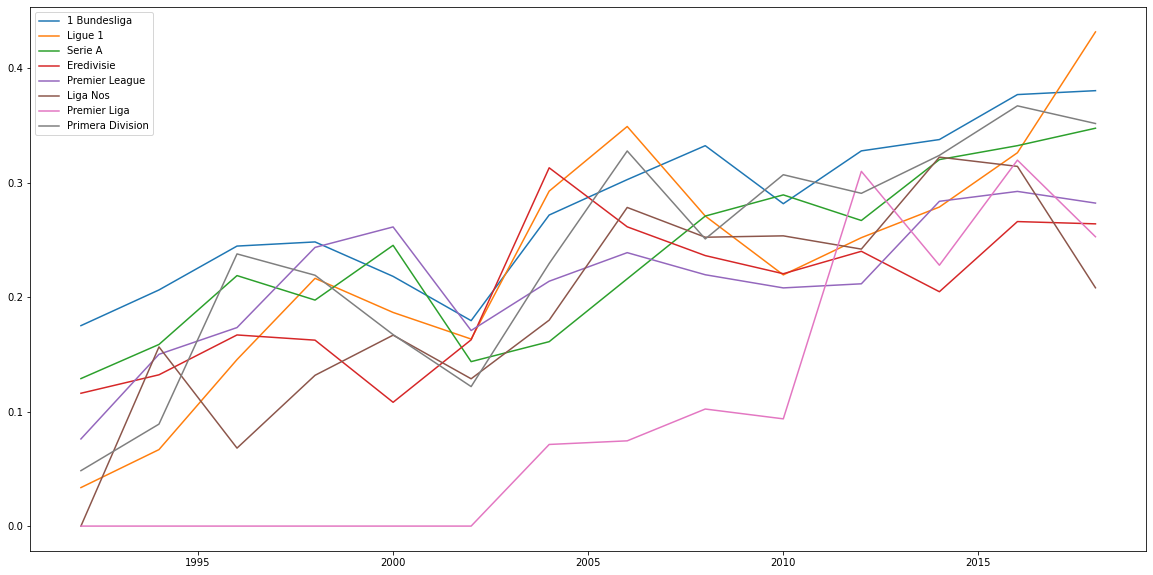

In [103]:
plt.figure(figsize=(20,10))
for p in partecipations:
    plt.plot(years[::2], np.mean(np.reshape(partecipations[p],(-1,2)), axis=1), label=p)
    #plt.plot(years, partecipations[p], label=p)
    
plt.legend()
plt.show()

#### Look at the roles of the teams

In [491]:
def display_roles(filename, z1=0.8, z2=3, P1=0.4):
    g = Graph.Load(filename)
    names = np.array(g.vs['name'])

    z = get_zscore(g)
    P = get_partecipation(g)

    int_clubs = names[np.intersect1d(np.where(z <= z1), np.where(P > P1))]
    loc_clubs = names[np.intersect1d(np.where(z <= z1), np.where(P <= P1))]
    int_hubs  = names[np.intersect1d(np.intersect1d(np.where(z1< z), np.where(z <= z2)), np.where(P > P1))]
    loc_hubs  = names[np.intersect1d(np.intersect1d(np.where(z1< z), np.where(z <= z2)), np.where(P <= P1))]
    int_dom   = names[np.intersect1d(np.where(z > z2), np.where(P > P1))]
    loc_dom   = names[np.intersect1d(np.where(z > z2), np.where(P <= P1))]
    
    
    plt.figure(figsize=(10,7))
    plt.margins(0)
    eps = 0.2
    P_eps = (P_bound+eps)/(1+eps) 
    plt.scatter(P, z)
    plt.xlim([0-eps, 1])
    plt.axhspan(min(z)-eps, z1, 0, P_eps, facecolor='green', alpha=0.4)
    plt.axhspan(min(z)-eps, z1,P_eps, 1, facecolor='yellow', alpha=0.4)
    plt.axhspan(z1, z2, 0, P_eps, facecolor='blue', alpha=0.4)
    plt.axhspan(z1, z2, P_eps, 1, facecolor='red', alpha=0.4)
    plt.axhspan(z2, max(z)+eps, 0, P_eps, facecolor='brown', alpha=0.4)
    plt.axhspan(z2, max(z)+eps, P_eps, 1, facecolor='gray', alpha=0.4)
    plt.xlabel('P')
    plt.ylabel('z')
    plt.savefig('temp_plot.png')
    plt.show()
    
    print('International dominers: ({}) \n {}'.format(int_dom.size, int_dom))
    print('\nLocal dominers: ({}) \n {}'.format(loc_dom.size, loc_dom))
    print('\nInternational hubs: ({}) \n {}'.format(int_hubs.size, int_hubs))
    print('\nLocal hubs: ({}) \n {}'.format(loc_hubs.size, loc_hubs))
    print('\nInternational clubs: ({}) \n {}'.format(int_clubs.size, int_clubs))
    print('\nLocal clubs: ({}) \n {}'.format(loc_clubs.size, loc_clubs))

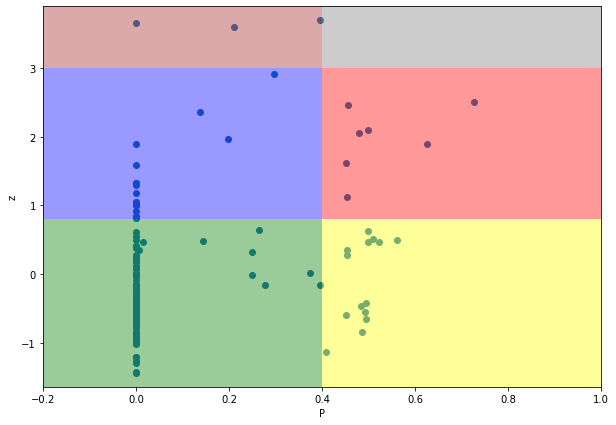

International dominers: (0) 
 []

Local dominers: (3) 
 ['Blackburn Rovers' 'Foggia Calcio_seller' 'Tottenham Hotspur_seller']

International hubs: (7) 
 ['Ajax Amsterdam' 'FC Internazionale' 'Arsenal FC' 'Milan AC'
 'Tottenham Hotspur' 'Ajax Amsterdam_seller' 'Nottm Forest_seller']

Local hubs: (18) 
 ['Borussia Dortmund' 'Real Madrid' 'Bayern Munich' 'Aston Villa'
 'Juventus FC' 'Liverpool FC' 'Sevilla FC_seller' 'Bragantino_seller'
 'Bayern Munich_seller' 'Twente FC_seller' 'Rapid Vienna_seller'
 'Southampton FC_seller' 'Feyenoord Rotterdam_seller'
 'VfB Stuttgart_seller' 'Liverpool FC_seller' 'Olympique Marseille_seller'
 'UC Sampdoria_seller' 'Lillestrøm SK_seller']

International clubs: (14) 
 ['SV Werder Bremen' '1.FC Nuremberg' '1.FC Kaiserslautern'
 'Feyenoord Rotterdam' 'RC Strasbourg Alsace' 'Bayer 05 Uerdingen'
 'Brescia Calcio' 'Chelsea FC' 'Sheffield United' 'Manchester United'
 'Sheffield Wednesday' 'SS Lazio' 'FC Internazionale_seller'
 'Juventus FC_seller']

Local club

In [492]:
display_roles('nets/1992/fee_net.net')